In [7]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Tank.csv",delimiter=";")

In [6]:
df.timestamp = pd.to_datetime(df.timestamp)

Text(0.5, 0, 'date')

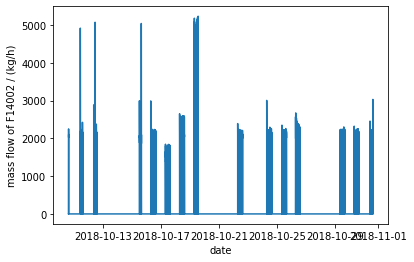

In [8]:
plt.plot(df['timestamp'],df['FIC14002_PV_Out ValueY'])
plt.ylabel('mass flow of F14002 / (kg/h)')
plt.xlabel('date')

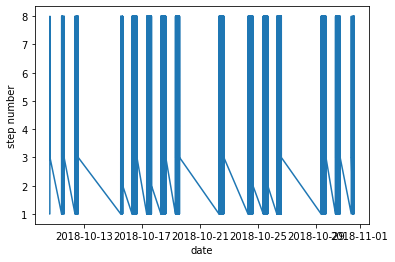

In [9]:
plt.plot(df['timestamp'],df['CuStepNo ValueY'])
plt.ylabel('step number')
plt.xlabel('date')
plt.show()

In [ ]:

import datetime
import matplotlib.pyplot as plt

# import data to data frame
n=datetime.datetime.now()
df=pd.read_csv('SmA-Four-Tank-Batch-Process_V2.csv',delimiter=';')
n2=datetime.datetime.now()

# print first lines of data frame
print(df.head())
# print data types
print(df.dtypes)
# timestamp is an object, not a timestamp
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%dT%H:%M:%S.%f')

print('Nach Umwandlung in ein Datumsformat:')
print('Erster Zeitstempel: {}'.format(df.at[1,'timestamp']))
print('Differenz der Zeitstempel: {}'.format(df['timestamp'].diff()))
print('Format des Zeitstempels: {}'.format(df['timestamp'].dtype))
# save data frame as pickle - more efficient
df.to_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
# read data frame from pickle
n3=datetime.datetime.now()
df=pd.read_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
n4=datetime.datetime.now()

print('Time to read data into data frame from csv: {}'.format(n2-n))
print('Time to read data into data frame from pickle: {}'.format(n4-n3))
# print columns of data frame
print(df.columns)
# plot column FIC14002_PV_Out ValueY (flow rate)
plt.subplot(121)
plt.plot(df['timestamp'],df['FIC14002_PV_Out ValueY'])
plt.ylabel('mass flow of F14002 / (kg/h)')
plt.xlabel('date')
# plot step number
plt.subplot(122)
plt.plot(df['timestamp'],df['CuStepNo ValueY'])
plt.ylabel('step number')
plt.xlabel('date')
plt.show()
# filter dataframe by step 1
df1=df[df['CuStepNo ValueY']==1]
print(df.describe())
print(df1.describe())
print('Shape of df (all steps): {}'.format(df.shape))
print('Shape of df1 (step 1): {}'.format(df1.shape))

In [ ]:
import pandas as pd
# read data frame from pickle
df=pd.read_pickle('SmA-Four-Tank-Batch-Process_V2.pkl')
# remove steps data are not mentioned in the documentation
vsteps=[1,7,8,3]
df=df[df['CuStepNo ValueY'].isin(vsteps)]
# determine start and end of steps
df['dstep_p']=df['CuStepNo ValueY'].diff()
df['dstep_n']=df['CuStepNo ValueY'].diff(-1)
# select rows with a step change
dfsen=df[(df['dstep_n']!=0)]
dfsep=df[(df['dstep_p']!=0)]
dfse=pd.concat([dfsen,dfsep])
dfse=dfse.sort_values(by=['timestamp'])
# create new dataframe where we store extracted information
dfinfo_steps=pd.DataFrame(columns=['step_length','start','end','stepn'])
# iterative approach
pstep=-1
c=0
for n in range(dfse.shape[0]):
    # get row
    r=dfse.iloc[n]
    if pstep==r['CuStepNo ValueY']:
        # determine step length
        stepl=r['timestamp']-dfse.iloc[n-1]['timestamp']
        # update dataframe
        dfinfo_steps.loc[c]=(stepl,dfse.iloc[n-1]['timestamp'],r['timestamp'],r['CuStepNo ValueY'])
        c=c+1
    else:
        pstep=r['CuStepNo ValueY']
print(dfinfo_steps.head())
print('Max step_length: {}'.format(dfinfo_steps['step_length'].max()))
print('Min step_length: {}'.format(dfinfo_steps['step_length'].min()))
print('#steps: {}'.format(dfinfo_steps.shape[0]))
# now determine whether the batch is complete
batchn=1
batchi=-1
dfinfo_steps["batchn"]=0
dfinfo_steps["is_complete"]=False
dfinfo_batches=pd.DataFrame(columns=['batch_length','start','end','steps','batchn','is_complete'])
n=0
b=0
while True:
    if n+len(vsteps)>dfinfo_steps.shape[0]:
        # complete info at incomplete, last batch
        steps=[]
        for v in range(dfinfo_steps.shape[0]-n):
            dfinfo_steps.at[n+v,'batchn']=batchi
            dfinfo_steps.at[n+v,'is_complete']=False
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+v,'end'],steps,batchi,False]
        b=b+1
        break
    # check if all steps of a batch are present and in correct order
    isCorrect=True
    for v in range(len(vsteps)):
        isCorrect=dfinfo_steps.loc[n+v,'stepn']==vsteps[v]
        if not isCorrect:
            break
    if isCorrect:
        steps=[]
        for v in range(len(vsteps)):
            dfinfo_steps.at[n+v,'batchn']=batchn
            dfinfo_steps.at[n+v,'is_complete']=True
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+v,'end'],steps,batchn,True]
        n=n+len(vsteps)
        batchn=batchn+1
        b=b+1
    else:
        steps=[]
        for vc in range(v):
            dfinfo_steps.at[n+vc,'batchn']=batchi
            dfinfo_steps.at[n+vc,'is_complete']=False
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+vc,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+vc,'end'],steps,batchi,False]
        batchi=batchi-1
        n=n+vc
        b=b+1
# save dfinfo_steps to file
dfinfo_steps.to_pickle('SmA-Four-Tank-Info-Steps.pkl')
dfinfo_batches.to_pickle('SmA-Four-Tank-Info-Batches.pkl')

In [ ]:
import pandas as pd
dfinfo_steps=pd.read_pickle('SmA-Four-Tank-Info-Steps.pkl')
dfinfo_batches=pd.read_pickle('SmA-Four-Tank-Info-Batches.pkl')
print('#complete batches: {}'.format(dfinfo_steps['batchn'].max()))
print('#incomplete batches: {}'.format(abs(dfinfo_steps['batchn'].min())))
print('step#\tshortest\tlongest')
for v in set(dfinfo_steps['stepn']):
    tmp=dfinfo_steps[dfinfo_steps['stepn']==v]
    print('{}\t{}\t\t{}'.format(v,tmp['step_length'].min().total_seconds(),tmp['step_length'].max().total_seconds()))
print('Longest batch: {}'.format(dfinfo_batches['batch_length'].max()))
print('Shortest batch: {}'.format(dfinfo_batches['batch_length'].min()))
